# 18.4 트랜스포머

- 트랜스포머(transformer)는 기계번역 등을 위한 인코더-디코더 구조를 순환 신경망을 사용하지 않고 어텐션만으로 구현한 모델이다. 

- 이번 장에서는 플럭스로 구현된 트랜스포머 모델을 제공하는 Transformers.jl 패키지를 이용하여 바로 앞 18.3절의 텍스트 분류 문제에 트랜스포머 인코더를 사용해 본다. 

In [1]:
using Pkg
Pkg.activate("/home/bread/JULIA/chap4")
Pkg.instantiate()

  Activating project at `~/JULIA/chap4`


## 18.1 데이터셋 준비 및 학습, 텍스트 함수

새로 만드는 모델도 정수 인코딩된 단어 시퀀스를 입력으로 받으므로 데이터셋 준비 과정은 앞 절과 동일하다. prepare_corpus, get_data, train, test, run_batch 함수까지 모두 그대로 사용한다. 

In [2]:
# 18.3절 코드 동일

using CSV, DataFrames
import MLUtils
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using TextAnalysis
using Random: MersenneTwister

# 1. corpus 준비 함수 설정 (prepare_corpus)
function prepare_corpus()
    imdb = CSV.read("IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "" => " ")
    X = X.|> tokenize

    X_crps = Corpus(TokenDocument.(X))
    prepare!(X_crps, strip_corrupt_utf8)
    prepare!(X_crps, strip_case)
    prepare!(X_crps, stem_words)
    prepare!(X_crps, strip_non_letters)
    prepare!(X_crps, strip_articles)
    prepare!(X_crps, strip_prepositions)
    prepare!(X_crps, strip_pronouns)
    prepare!(X_crps, strip_stopwords)

    imdb, X_crps
end

# 2. 데이터 수집 함수 작성 (get_data)
function get_data(num_words, seq_len, batch_size)
    imdb, X_crps = prepare_corpus()
    
    update_lexicon!(X_crps)
    lexi = lexicon(X_crps)
    sorted = map(x -> x[1], sort(collect(lexi), by = x->x[2], rev=true))
    top_words = first(filter(x -> x != "", sorted), num_words)
    word_idx = Dict(x => i + 1 for (i, x) in enumerate(top_words))     
    
    X = map(X_crps) do crp
        idx = map(x -> get(word_idx, x, 0), crp.tokens)
        idx = filter(x -> x != 0, idx)
        if length(idx) > seq_len
            idx[1:seq_len]
        else
            vcat(idx, fill(1, seq_len - length(idx)))
        end
    end
    X = MLUtils.batch(X)
    
    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batch_size)
    test_loader = MLUtils.DataLoader(test, batchsize=batch_size)
    
    train_loader, test_loader, top_words
end

# 3. 트레이닝 함수 작성 (train)
function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

# 4. 테스트 함수 작성 (test)
function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += batch_size
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", acc, avg_loss)
    acc, avg_loss
end

# 5. 배치 실행 함수 작성(run_batch)
function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, X, y) = Flux.Losses.logitcrossentropy(m(X), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epochs $t")
            println("------------------------------------------")
            model, optimizer, loss = train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, loss)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end


run_batch (generic function with 1 method)

## 18.2 모델 정의

1. Transformers.jl 패키지 로딩

2. 모델 타입 정의 

3. 정방향 진행 객체 호출 함수 정의

4. 모델 생성함수 정의

In [3]:
# 1. Transformers.jl 패키지 로딩

using Transformers

In [4]:
# 2. 모델 타입 정의

import Functors
struct MyTrns
    embed    # 단어 임베딩
    pos_emb  # 위치 임베딩
    trns     # 트랜스포머
    pool     # 풀링
    dense1   # 밀집층 1
    dropout  # 드롭아웃
    dense2   # 밀집층 2
end 

Functors.@functor MyTrns

"""
앞 절의 MyRNN 모델에서 양방향 LSTM층 및 어텐션 층이 위치 임베딩과 트랜스포머층, 풀링층으로 바뀜
모델의 정방향 진행에 쓰이는 객체 호출 함수는 다음과 같음
"""

# 3. 모델 정방향 진행 객체 호출 함수

function (a::MyTrns)(X)             # (seq, bat)
    X = a.embed(X) .+ a.pos_emb(X)  # (emb, seq, bat)
    X = a.trns((; hidden_state = X)).hidden_state # (emb, seq, bat)
    X = permutedims(X, (2,1,3))     # (seq, emb, bat)
    X = dropdims(a.pool(X), dims=1) # (emb, bat)
    X = a.dense1(a.dropout(X))
    a.dense2(a.dropout(X))
end
     

단어 임베딩에 위치 임베딩을 더한 임베딩 벡터는 트랜스포머층을 거쳐서 문맥을 반영한 임베딩 벡터가 된다. 이를 시퀀스 축에 대해 풀링을 한 다음 밀집층을 거쳐서 문서 분류 로짓을 산출한다. 위치 임베딩은 배치 크기만큼 중복 계산되는 것이 아니라 한 번만 계산되므로 단어 임베딩에 더해 줄때 브로드캐스팅 한다. 

트랜스포머층은 내부적으로 N층의 입출력 형상이 같은 트랜스포머 블록으로 이루어진다. 트랜스포머층 안에 있는 셀프 어텐션은 입력된 임베딩 시퀀스의 각 임베딩을 시퀀스 내 다른 임베딩들과의 유사성으로 가중평균한 새로운 임베딩 시퀀스를 출력하기 때문에 출력 결과는 문맥을 반영하게 된다.

모델 생성 함수는 다음과 같다. 

In [5]:
# 4. 모델 생성 함수

function build_model(emb; head = 4, hs = 64, preLN = false)
    embed = Flux.Embedding(emb)
    embed_size = size(embed.weight, 1)
    pos_emb = Layers.SinCosPositionEmbed(embed_size)
    block = preLN ? Layers.PreNormTransformerBlock : Layers.TransformerBlock 
    num_layer = 2
    head_hidden = embed_size ÷ head
    ffn_dim = 4 * embed_size
    trns = Transformer(block, num_layer, head, embed_size, head_hidden, ffn_dim)
    MyTrns(
        embed,
        pos_emb, 
        trns,
        #trns2,
        Flux.GlobalMeanPool(),
        Flux.Dense(embed_size => hs, Flux.relu),
        Flux.Dropout(0.5), 
        Flux.Dense(hs => 2))
end
     

build_model (generic function with 1 method)

코드 설명

- emb: 단어 임베딩층에 바로 넘길 인수
    + 임베딩 층의 차원을 지정할 수도 있고, GloVe와 같은 사전 학습된 단어 임베딩 가중치를 넘길 수도 있음

- 위치 임베딩층: 위치 인덱스에 따라 사인/코사인 값이 정해진 Layers.SinCosPositionEmbed 사용
    + 학습 가능한 위치 임베딩을 사용하려면 Layers.FixedLenPositionEmbed를 사용
    
- Transformer 층: 생성자에서 트랜스포머 블록 타입과 층수, 헤드 수, 임베딩 벡터 크기, 헤드의 은닉 차원, 위치별(position-wise) 피드 포워드 층의 은닉 차원을 지정
    + 피드 포워드 층의 활성화 함수, 드롭아웃 비율 등도 키워드 인수로 지정 가능
    + 트랜스포머 블록 타입은 인코더인지 디코더인지, 그리고 층 정규화 순서를 어떻게 할지 등에 따라 선택할 수 있음
        * 여기서는 인코더만 사용하므로, 층 정규화 관련 인수인 preLN에 따라서만 블록 타입을 선택

- 트랜스포머층을 통과한 시퀀스에 대한 풀링은 전체에 평균을 취하는 GloablMeanPool 층을 사용

## 18.3 학습 결과

In [6]:
# 학습 인수 설정

num_words = 10000;
seq_len = 300;
batch_size = 64;
embed_size = 128;

In [8]:
# 데이터 불러오기
@time begin
    train_loader, test_loader, top_words = get_data(num_words, seq_len, batch_size);
end

 88.515571 seconds (1.17 G allocations: 59.463 GiB, 19.75% gc time)


(DataLoader(::Tuple{SubArray{Int64, 2, Matrix{Int64}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}, SubArray{Bool, 2, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, false}}, batchsize=64), DataLoader(::Tuple{SubArray{Int64, 2, Matrix{Int64}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, true}, SubArray{Bool, 2, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}, Tuple{Base.Slice{Base.OneTo{Int64}}, UnitRange{Int64}}, false}}, batchsize=64), String[])

In [9]:
# 베이스 모델 설정 

model_base = build_model(num_words + 1 => embed_size, hs = 64)

MyTrns(Embedding(10001 => 128), SinCosPositionEmbed(default_position_func(static(128)), 128, normalized = false), Transformer<2>(PostNormTransformerBlock(DropoutLayer<nothing>(SelfAttention(MultiheadQKVAttenOp(head = 4, p = nothing), NSplit<3>(Dense(W = (128, 384), b = true)), Dense(W = (128, 128), b = true))), LayerNorm(128, ϵ = 1.0e-7), DropoutLayer<nothing>(Chain(Dense(σ = NNlib.gelu, W = (128, 512), b = true), Dense(W = (512, 128), b = true))), LayerNorm(128, ϵ = 1.0e-7))), GlobalMeanPool(), Dense(128 => 64, relu), Dropout(0.5), Dense(64 => 2))

In [10]:
# 배치 실행 
@time begin
    models = [model_base] .|> Flux.gpu
    losses, accus = run_batch((train_loader, test_loader), models, 10);
end

[Model 1] Epochs 1
------------------------------------------
[Train] loss: 0.6985544 [100/547]
[Train] loss: 0.7215750 [200/547]
[Train] loss: 0.6954484 [300/547]
[Train] loss: 0.6926867 [400/547]
[Train] loss: 0.6842720 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931664
[Model 1] Epochs 2
------------------------------------------
[Train] loss: 0.6939546 [100/547]
[Train] loss: 0.6912423 [200/547]
[Train] loss: 0.6893962 [300/547]
[Train] loss: 0.6951400 [400/547]
[Train] loss: 0.6941480 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931471
[Model 1] Epochs 3
------------------------------------------
[Train] loss: 0.6891414 [100/547]
[Train] loss: 0.6948257 [200/547]
[Train] loss: 0.6912766 [300/547]
[Train] loss: 0.6900288 [400/547]
[Train] loss: 0.6921952 [500/547]
[Test] Accuracy: 49.8, Avg loss: 0.6931492
[Model 1] Epochs 4
------------------------------------------
[Train] loss: 0.6934228 [100/547]
[Train] loss: 0.6921835 [200/547]
[Train] loss: 0.6949450 [300/547]
[Train] los

(Any[Any[0.69855434f0, 0.72157496f0, 0.69544834f0, 0.6926867f0, 0.68427205f0, 0.69395465f0, 0.6912423f0, 0.6893962f0, 0.69514006f0, 0.69414806f0  …  0.6924361f0, 0.69182473f0, 0.6931898f0, 0.6925362f0, 0.6938132f0, 0.6935407f0, 0.69196504f0, 0.6927215f0, 0.69313484f0, 0.6938994f0]], Any[Any[49.933510638297875, 49.933510638297875, 49.80053191489361, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875]])

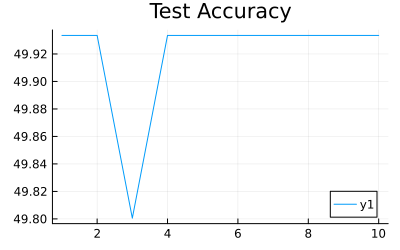

In [11]:
# 에폭별 모델 정확도 확인 
import Plots
Plots.gr(size=(400,250))
Plots.plot(accus, title="Test Accuracy")

## 18.4 정규화 순서 바꾸기

- 원 트랜스포머 논문의 트랜스포머 층은 **스킵 연결**(skip connection) 다음에 **층 정규화**(layer normalization)를 두는 사후 층 정규화를 사용
    - 이 방식은 학습이 안정적이지 않아서 학습률을 점진적으로 증가시키는 학습률 웜업(warm up) 단계를 사용하기도 함
    - 이를 개선하기 위해 층 정규화를 스킵 커넥션 안에 두는 사전 층 정규화 방식을 사용할 수 있음 

In [12]:
# 정규화 순서 바꾸기 preLN

model_base2 = build_model(num_words + 1 => embed_size, hs = 64, preLN = true)

@time begin
    models2 = [model_base2] .|> Flux.gpu
    losses, accus = run_batch((train_loader, test_loader), models2, 10);
end

[Model 1] Epochs 1
------------------------------------------
[Train] loss: 0.6933222 [100/547]
[Train] loss: 0.7177344 [200/547]
[Train] loss: 0.7042173 [300/547]
[Train] loss: 0.6946226 [400/547]
[Train] loss: 0.6920926 [500/547]
[Test] Accuracy: 49.8, Avg loss: 0.6931816
[Model 1] Epochs 2
------------------------------------------
[Train] loss: 0.6969220 [100/547]
[Train] loss: 0.6875670 [200/547]
[Train] loss: 0.6901564 [300/547]
[Train] loss: 0.6934446 [400/547]
[Train] loss: 0.6957626 [500/547]
[Test] Accuracy: 49.9, Avg loss: 0.6931470
[Model 1] Epochs 3
------------------------------------------
[Train] loss: 0.6973281 [100/547]
[Train] loss: 0.6923446 [200/547]
[Train] loss: 0.6915047 [300/547]
[Train] loss: 0.7034142 [400/547]
[Train] loss: 0.6930440 [500/547]
[Test] Accuracy: 49.8, Avg loss: 0.6931498
[Model 1] Epochs 4
------------------------------------------
[Train] loss: 0.6891483 [100/547]
[Train] loss: 0.6912958 [200/547]
[Train] loss: 0.6940958 [300/547]
[Train] los

(Any[Any[0.6933222f0, 0.71773446f0, 0.7042173f0, 0.69462264f0, 0.69209266f0, 0.69692194f0, 0.687567f0, 0.69015634f0, 0.6934446f0, 0.6957626f0  …  0.6939911f0, 0.6918359f0, 0.69365776f0, 0.69270205f0, 0.70161396f0, 0.688346f0, 0.6908066f0, 0.6932112f0, 0.6916747f0, 0.6936765f0]], Any[Any[49.80053191489361, 49.933510638297875, 49.80053191489361, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.933510638297875, 49.80053191489361]])

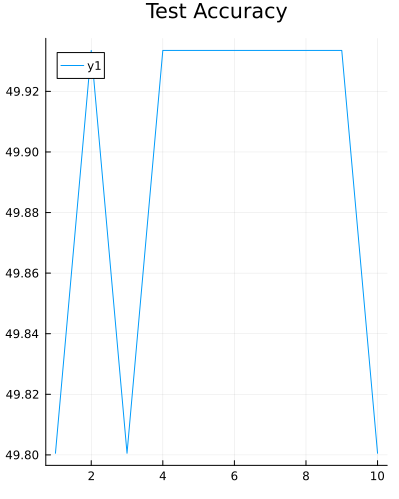

In [13]:
import Plots
Plots.gr(size = (400, 500))
Plots.plot(accus, title = "Test Accuracy")